In [1]:
!pip install pandas
import pandas as pd
import numpy as np
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install seaborn
import seaborn as sns
!pip install opencv-python
!pip install opencv-python-headless
import cv2
import glob

%matplotlib inline

  Using cached python_dateutil-2.8.2-py2.py3-none-any.whl (247 kB)
  Using cached pytz-2022.7.1-py2.py3-none-any.whl (499 kB)
  Attempting uninstall: pytz
    Found existing installation: pytz 2015.7
    Uninstalling pytz-2015.7:
      Successfully uninstalled pytz-2015.7
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.4.2
    Uninstalling python-dateutil-2.4.2:
      Successfully uninstalled python-dateutil-2.4.2


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tsheets 0.3 requires python-dateutil==2.4.2, but you have python-dateutil 2.8.2 which is incompatible.
tsheets 0.3 requires pytz==2015.7, but you have pytz 2022.7.1 which is incompatible.
rasa 3.1.0 requires numpy<1.20.0,>=1.19.2, but you have numpy 1.23.5 which is incompatible.
rasa 3.1.0 requires packaging<21.0,>=20.0, but you have packaging 21.3 which is incompatible.
rasa 3.1.0 requires pytz<2022.0,>=2019.1, but you have pytz 2022.7.1 which is incompatible.
rasa 3.1.0 requires typing-extensions<4.0.0,>=3.7.4, but you have typing-extensions 4.2.0 which is incompatible.


     ---------------------------------------- 38.2/38.2 MB 1.4 MB/s eta 0:00:00
     ---------------------------------------- 38.1/38.1 MB 2.1 MB/s eta 0:00:00


In [31]:
!pip install xlrd

     -------------------------------------- 96.5/96.5 kB 791.7 kB/s eta 0:00:00


In [40]:
labels_df = pd.read_csv("labels.csv")

labels = np.array(labels_df[' hemorrhage'].tolist())

files = sorted(glob.glob('head_ct/*.png'))
images = np.array([cv2.imread(path) for path in files])



C:\Users\Waleed\AppData\Local\Temp/ipykernel_280/1701771392.py:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  images = np.array([cv2.imread(path) for path in files])


# Initial data exploration

<AxesSubplot:>

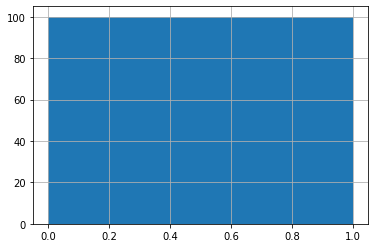

In [41]:
labels_df[' hemorrhage'].hist(bins=2)

There is the same amount of data for both cases.

In [42]:
images_df = pd.DataFrame(images, columns=['image'])

In [43]:
images_df['width'] = images_df['image'].apply(lambda x: x.shape[0])
images_df['height'] = images_df['image'].apply(lambda x: x.shape[1])

array([[<AxesSubplot:title={'center':'height'}>,
        <AxesSubplot:title={'center':'width'}>]], dtype=object)

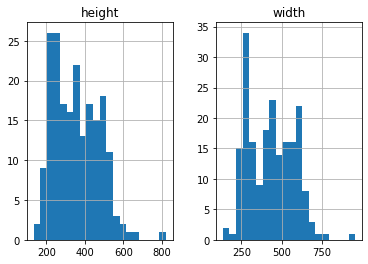

In [44]:
images_df[['height', 'width']].hist(bins=20)

In [45]:
images_df[['height', 'width']].describe()

,height,width
count,200.000000,200.000000
mean,355.505000,433.720000
std,116.785247,142.059481
min,134.000000,135.000000
25%,252.000000,298.750000
50%,345.000000,435.500000
75%,447.250000,554.000000
max,821.000000,957.000000


Now we will resize all the images to same size
 

In [46]:
images = np.array([cv2.resize(image, (128, 128)) for image in images])

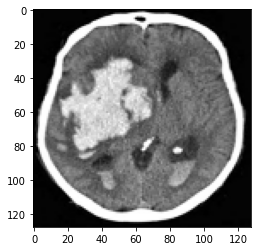

In [48]:
plt.imshow(images[5])

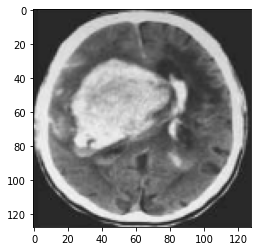

In [49]:
plt.imshow(images[10])

The quality of images seems to be acceptable.

# Adding flipped images

We could also improve the dataset by adding flipped images. By adding flipped images to dataset, we can greatly increase the accuracy of model.

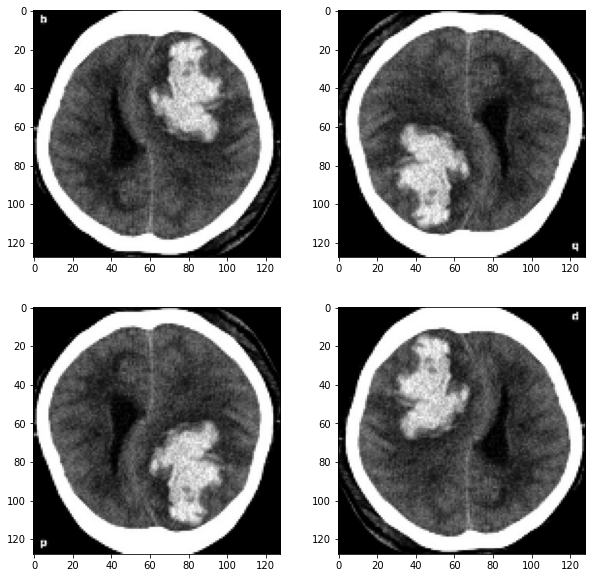

In [51]:
plt.figure(figsize=(10, 10))
for i, flip in enumerate([None, -1, 0, 1]):
    plt.subplot(221 + i)
    if flip is None:
        plt.imshow(images[0])
    else:
        plt.imshow(cv2.flip(images[0], flip))

Split data into train, validation and test subsets.

In [52]:
print(labels)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


In [53]:
indicies = np.random.permutation(100)
train_true_idx, test_true_idx = indicies[:90], indicies[90:]
train_false_idx, test_false_idx = indicies[:90] + 100, indicies[90:] + 100
train_idx, test_idx = np.append(train_true_idx, train_false_idx), np.append(test_true_idx, test_false_idx)

train_validationX, train_validationY = images[train_idx], labels[train_idx]
testX, testY = images[test_idx], labels[test_idx]

print(train_validationX.shape, testX.shape)
print(train_validationY.shape, testY.shape)

(180, 128, 128, 3) (20, 128, 128, 3)
(180,) (20,)


In [54]:
# Splitting train and validation sets
tr_len = train_validationX.shape[0]
train_val_split = int(tr_len*0.9)
indicies = np.random.permutation(tr_len)
train_idx, validation_idx = indicies[:train_val_split], indicies[train_val_split:]

trainX, trainY = train_validationX[train_idx], train_validationY[train_idx]
validationX, validationY = train_validationX[validation_idx], train_validationY[validation_idx]

print(trainX.shape, validationX.shape)
print(trainY.shape, validationY.shape)

(162, 128, 128, 3) (18, 128, 128, 3)
(162,) (18,)


In [55]:

import keras

In [56]:
from keras.models import Sequential
from keras.layers import Dense, Input, Flatten, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D, GlobalMaxPooling2D
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

import math

# Image augmentation

In [58]:
train_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=180,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0
)
validation_image_data = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.,
    zoom_range=0.05,
    rotation_range=90,
    width_shift_range=0.05,
    height_shift_range=0.05,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='constant',
    cval=0)

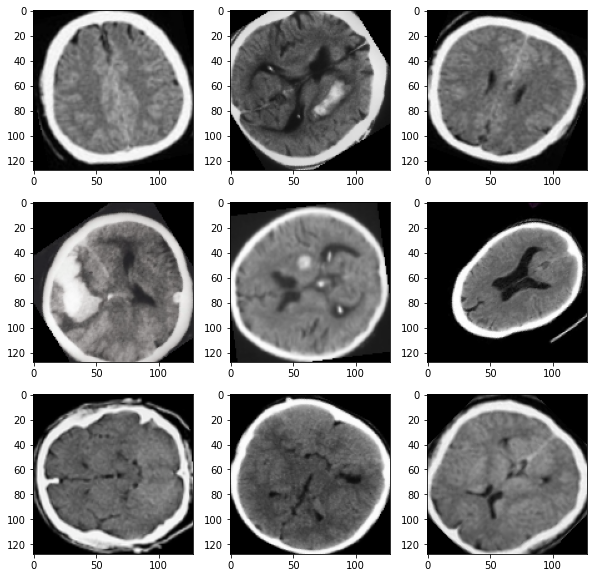

In [60]:
plt.figure(figsize=(10, 10))
for X_batch, y_batch in train_image_data.flow(trainX, trainY, batch_size=10): #batch size refers to the images passed at once, increasing this will lead to overfitting
    for i in range(0, 9):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

# Building the model

In [61]:
def check_accuracy(model, setX, actual, print_images=True):
    predicted = np.array([int(x[0] > 0.5) for x in model.predict(setX)])
    if print_images:
        rows = math.ceil(len(predicted)/10.)
        plt.figure(figsize=(20, 3 * rows))
        for i in range(len(predicted)):
            plt.subplot(rows, 10, i+1)
            plt.imshow(setX[i])
            plt.title("pred "+str(predicted[i])+" actual "+str(actual[i]))
        
    confusion = confusion_matrix(actual, predicted)
    tn, fp, fn, tp = confusion.ravel()
    print("True positive:", tp, ", True negative:", tn,
          ", False positive:", fp, ", False negative:", fn)

    print("Total accuracy:", np.sum(predicted==actual) / len(predicted) * 100., "%")
    return (tn, fp, fn, tp)

In [62]:
def simple_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [63]:
model = simple_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [64]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 global_average_pooling2d (G  (None, 64)               0

# Training model

In [71]:
model.fit_generator(train_image_data.flow(trainX, trainY, batch_size=16),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint("weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=16)

C:\Users\Waleed\AppData\Local\Temp/ipykernel_280/1171155845.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_image_data.flow(trainX, trainY, batch_size=16),


Epoch 1/16
128/128 [==============================] - 1s 7ms/step - loss: 0.7002 - accuracy: 0.5370 - val_loss: 0.6906 - val_accuracy: 0.5556


True positive: 0 , True negative: 10 , False positive: 0 , False negative: 8
Total accuracy: 55.55555555555556 %


(10, 0, 8, 0)

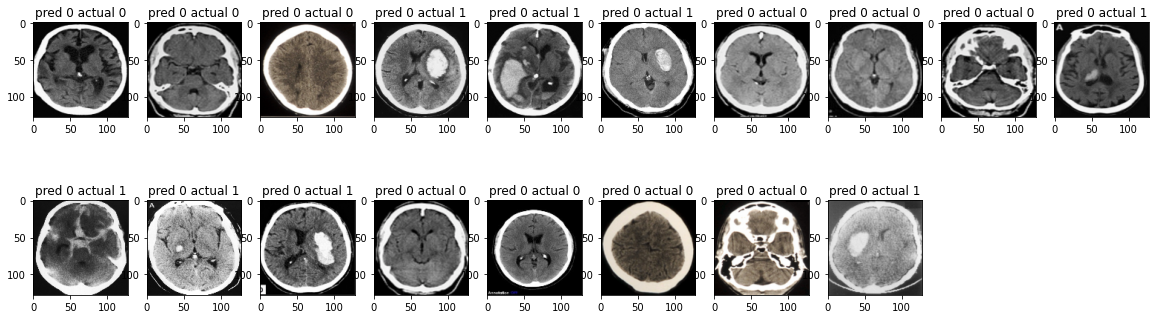

In [72]:
check_accuracy(model, validationX/255., validationY)

In [25]:
model.save("last-weights.h5")
model.load_weights("weights.h5")

In [73]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 0 , True negative: 80 , False positive: 0 , False negative: 82
Total accuracy: 49.382716049382715 %


(80, 0, 82, 0)

True positive: 0 , True negative: 10 , False positive: 0 , False negative: 8
Total accuracy: 55.55555555555556 %


(10, 0, 8, 0)

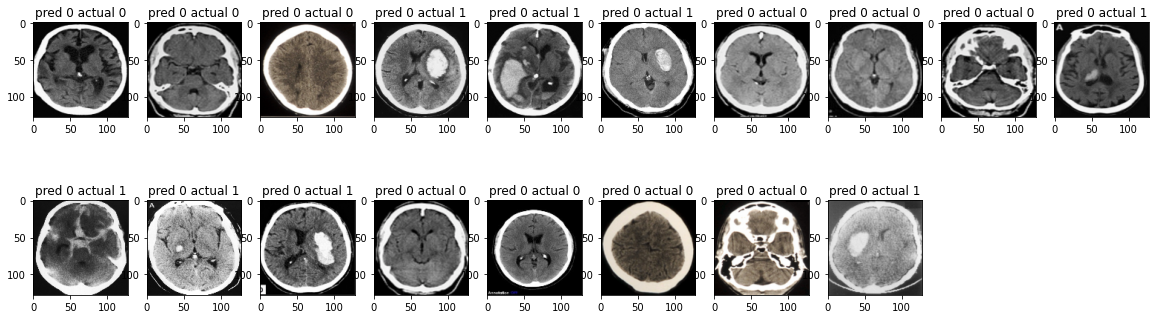

In [74]:
check_accuracy(model, validationX/255., validationY)

The overall generalization of model seems good, overfitting isn't too big. But since this is a medical problem, we have to consider one additional thing.

# False negative result will kill patient
False negative is not good here since it is a matter of life and death. This means that the model won't be able to classify a response as positive and would flag it as negative

In [75]:
def imbalance_set(coeff=2):
    imbalanced_trainX = []
    imbalanced_trainY = []
    for i, train_x in enumerate(trainX):
        def add_entry(x, y):
            imbalanced_trainX.append(x)
            imbalanced_trainY.append(y)

        add_entry(train_x, trainY[i])

        if(trainY[i] == 1):
            for j in range(coeff-1):
                add_entry(train_x, trainY[i])
    return (np.array(imbalanced_trainX), np.array(imbalanced_trainY))

imbalanced_trainX, imbalanced_trainY = imbalance_set(2)
print(imbalanced_trainX.shape, imbalanced_trainY.shape)

(244, 128, 128, 3) (244,)


In [76]:
def bigger_conv_model(input_shape):
    model = Sequential()
    
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu'))
    
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.4))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.4))
    
    model.add(Dense(1, activation='sigmoid'))
    return model

In [77]:
model = bigger_conv_model((128, 128, 3))
model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 4, 4, 64)          18496     
                                                                 
 global_average_pooling2d_1   (None, 64)              

In [83]:
model.fit_generator(train_image_data.flow(imbalanced_trainX, imbalanced_trainY, batch_size=16),
    steps_per_epoch=128,
    validation_data=validation_image_data.flow(validationX, validationY, batch_size=16),
    validation_steps=100,
    callbacks=[ModelCheckpoint("bigger_model_checkpoint_weights.h5", monitor='val_acc', save_best_only=True, mode='max')],
    epochs=24)

Epoch 1/24
  1/128 [..............................] - ETA: 10s - loss: 0.7305 - accuracy: 0.5625

C:\Users\Waleed\AppData\Local\Temp/ipykernel_280/1876211278.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  model.fit_generator(train_image_data.flow(imbalanced_trainX, imbalanced_trainY, batch_size=16),


128/128 [==============================] - 1s 11ms/step - loss: 0.6329 - accuracy: 0.6721 - val_loss: 0.7794 - val_accuracy: 0.4444


In [84]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 82 , True negative: 0 , False positive: 80 , False negative: 0
Total accuracy: 50.617283950617285 %


(0, 80, 0, 82)

In [85]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 8 , True negative: 0 , False positive: 10 , False negative: 0
Total accuracy: 44.44444444444444 %


(0, 10, 0, 8)

In [34]:
model.save("bigger_model_latest_weights.h5")
model.load_weights("bigger_model_checkpoint_weights.h5")

In [86]:
check_accuracy(model, trainX/255., trainY, False)

True positive: 82 , True negative: 0 , False positive: 80 , False negative: 0
Total accuracy: 50.617283950617285 %


(0, 80, 0, 82)

In [87]:
check_accuracy(model, validationX/255., validationY, False)

True positive: 8 , True negative: 0 , False positive: 10 , False negative: 0
Total accuracy: 44.44444444444444 %


(0, 10, 0, 8)

True positive: 10 , True negative: 0 , False positive: 10 , False negative: 0
Total accuracy: 50.0 %


(0, 10, 0, 10)

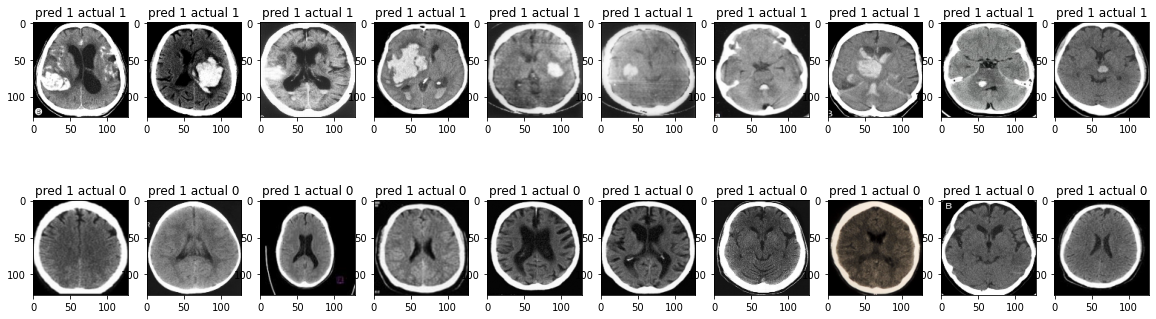

In [88]:
check_accuracy(model, testX/255., testY)

The model above can be improved pertaining to the fact that we need images with alteration of contrast


